In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas_profiling as pp
from datetime import datetime
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss

## Loading dataset

read dataset, define delimiter, dtypes and encoding

In [63]:
df = pd.read_csv('data.csv',
                 delimiter = ';',
                 encoding='utf-8',
                 dtype={"game_event_id":"str",
                        "game_id":"str"})

## Summarize data

In [64]:
# advanced way for df.describe()
pp.ProfileReport(df).to_file('report.html')

## data cleaning

In [65]:
# set 'game_date' as datetime
df["game_date"] = pd.to_datetime(df["game_date"], format="%d-%m-%Y")

In [66]:
# drop features with only 1 unique value
df = df.drop(['team_id', 'team_name'], axis=1)

In [67]:
# unnecessary columns, since they are correlated to loc_x and loc_y
df = df.drop(['lon', 'lat'], axis=1)

In [68]:
# higly correlated features between eachother can be removed
df = df.drop(['shot_id'], axis=1)

In [69]:
# time remaining, make a new one in seconds = minutes x 60sec + # sec
df['time_remaining_seconds'] = (df['minutes_remaining'] *60) + (df['seconds_remaining'])
df = df.drop(['minutes_remaining', 'seconds_remaining'], axis=1)

In [70]:
# game event ID's are irrelevant to the success of a shot
df = df.drop(['game_id','game_event_id'], axis=1)

## Feature engineering

relevant to the success of a shot

In [71]:
# get info from matchup: home or away?
df['home'] = df['matchup'].apply(lambda x: 1 if 'vs' in x else 0)
df = df.drop('matchup', axis=1)

In [72]:
# make a new feature out of "time_remaining_seconds"
df['last_3_seconds'] = df["time_remaining_seconds"].apply(lambda x: 1 if x < 4 else 0)

In [73]:
# Since the season variable represents the year,
# we only need to extract the month from the date variable.
# The weekday is unlikely to be relevant.

# make a new columns to only keep the months of the date, rest is irrelevant
df['game_month'] = df['game_date'].dt.month
df = df.drop('game_date', axis=1)

## Visualise features vs target

  - X-axis = any feature category
  - y-axis = target

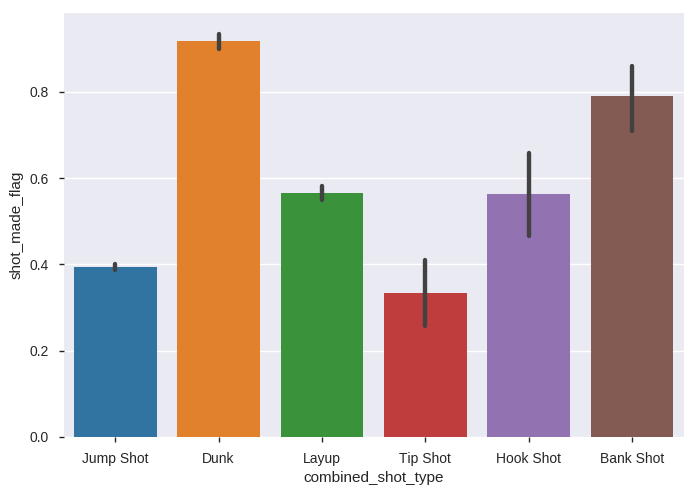

In [74]:
sns.barplot(x='combined_shot_type', y='shot_made_flag', data=df)

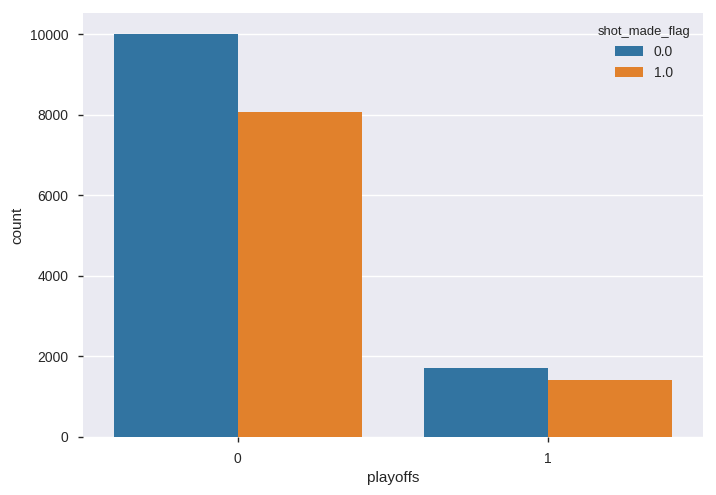

In [75]:
sns.countplot(x='playoffs', hue='shot_made_flag', data=df)
# The proportion of successful shots is similar in the two cases and
# does not seem to depend on the playoff variable.
# Therefore, this variable can be dropped.
df = df.drop('playoffs', axis=1)

## Transform Categorical data for modeling

In [76]:
df.shape

(25697, 17)

In [77]:
for var in df.select_dtypes(include='object').columns.values:
    df = pd.concat([df, pd.get_dummies(df[var], drop_first=True, prefix=var)], 1)
    df = df.drop(var, axis=1)

In [78]:
df.shape

(25697, 135)

## Create a training dataset & submission 'testing' dataset

In [79]:
# Kaggle already selected some rows and made them missing in the target variable:

# submission dataset (features X + target y)
df_test = df[df['shot_made_flag'].isnull()]

# training dataset (features X + target y), to train our models on
df_train = df[df['shot_made_flag'].notnull()]

## create the target dataset

In [80]:
# only target 'shot_made_flag'
y_train = df_train['shot_made_flag']

## create the features dataset

In [81]:
# no need to do a train_test_split(X, y, stratify=y, random_state=0)

# all features except the target
X_train = df_train.drop('shot_made_flag', axis=1)

# X = df.select_dtypes(exclude=["object"]).drop(['shot_made_flag', 'game_date'], axis=1)

## create the features for submission

In [82]:
# all features except the target (for submission)
X_test = df_test.drop('shot_made_flag', axis=1)

# y_test is secret only known by Kaggle

## Summarize the data

In [83]:
# advanced way for .describe method, overwite original report.html
#pp.ProfileReport(df_train).to_file('report.html')

## choose a model

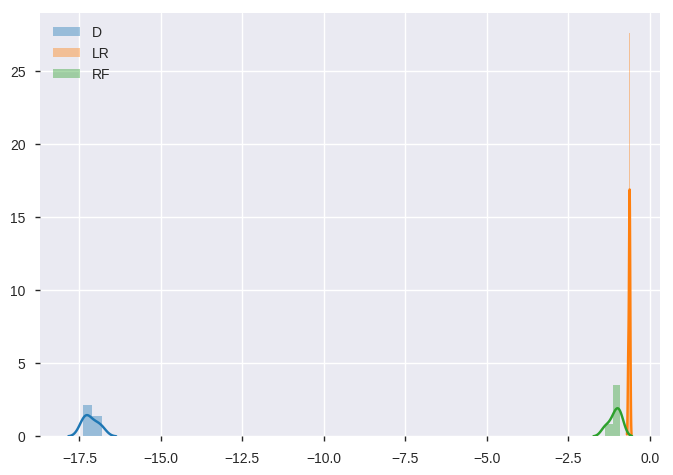

In [84]:
# compare these models: dummy, logistic, Forest, ...
models = []
models.append(('D', DummyClassifier()))
models.append(('LR', LogisticRegression()))
models.append(('RF', RandomForestClassifier()))

results = []

# choose the number of CV splits: 5
n_splits = 5

cv = StratifiedKFold(n_splits=n_splits, shuffle=False)

# choose the scoring metric: neg_log_loss
for name, model in models:
    score = cross_val_score(model, X_train, y_train, scoring='neg_log_loss', cv=cv, n_jobs=-1)
    results.append((name, score))
    sns.distplot(score, label=name)
    plt.legend()

results = pd.DataFrame(dict(results))

### RandomForest

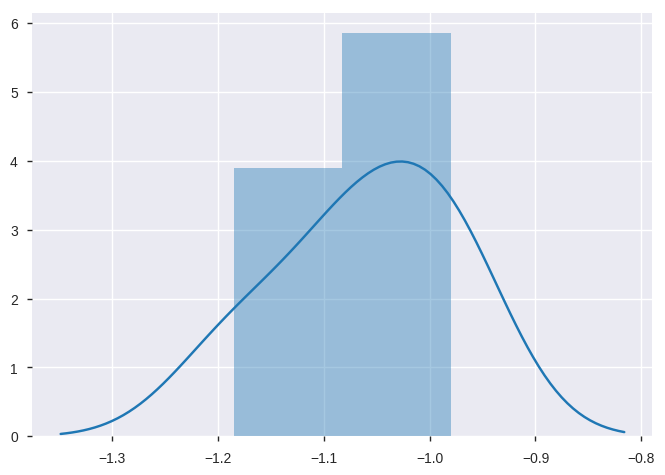

In [85]:
# choose the model, no hyperparameters
model = RandomForestClassifier()
# cross validation parameters
cv = StratifiedKFold(n_splits=n_splits, shuffle=False)
# calculate the scoring of the model for each fold
# n_jobs is set to multi-core processing
score = cross_val_score(model, X_train, y_train, scoring='neg_log_loss', cv=cv, n_jobs=-1)
# plot the distribution
sns.distplot(score)

## Hyperparameter tuning RandomForest

In [86]:
estimator = RandomForestClassifier()

In [87]:
params={'n_estimators':[10,20,30,100,300], 'max_depth':[5,10]}

In [88]:
# choose number of splits: 5
cv = StratifiedKFold(n_splits=5, shuffle=True)

In [89]:
grid = GridSearchCV(estimator, param_grid=params, scoring='neg_log_loss', cv=cv, n_jobs=-1)

In [134]:
# calculate the best parameters
grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [10, 20, 30, 100, 300], 'max_depth': [5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=0)

## hyperparameter Results

In [135]:
grid.__dict__

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py

{'scoring': 'neg_log_loss',
 'estimator': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False),
 'n_jobs': -1,
 'fit_params': None,
 'iid': 'warn',
 'refit': True,
 'cv': StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
 'verbose': 0,
 'pre_dispatch': '2*n_jobs',
 'error_score': 'raise-deprecating',
 'return_train_score': 'warn',
 'param_grid': {'n_estimators': [10, 20, 30, 100, 300], 'max_depth': [5, 10]},
 'multimetric_': False,
 'best_index_': 9,
 'best_params_': {'max_depth': 10, 'n_estimators': 300},
 'best_score_': -0.6159357260163265,
 'best_estimator_': RandomForestClassifier(bootstrap=True,

## final predictions

Create the Kaggle submission file

 * col1 = "shot_id"
 * col2 = "shot_made_flag"

In [92]:
# run the optimal model on the X_test
submission = pd.read_csv("sample_submission.csv", delimiter=";")

In [93]:
# create prediction values
# notice: the X_test has had the same feature cleaning, engineering, transformations !
submission['shot_made_flag'] = grid.predict_proba(X_test)[:,1]

In [94]:
# save file: submission.csv
submission.to_csv("submission.csv", index=False)

In [95]:
# comment out bad code, kaggle will testrun the code and calculate the submission file results leaderboard score

## Model Evaluation with the training dataset

we do not have access to the y_test

In [96]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

In [119]:
X = X_train
y = y_train
# choose the split size: 70/30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101, stratify=y)

## Evaluation based on optimal model (classification)

In [136]:
print(classification_report(y_test, grid.best_estimator_.predict(X_test) ))

              precision    recall  f1-score   support

         0.0       0.55      1.00      0.71      2637
         1.0       0.00      0.00      0.00      2133

   micro avg       0.55      0.55      0.55      4770
   macro avg       0.28      0.50      0.36      4770
weighted avg       0.31      0.55      0.39      4770



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [121]:
confusion_matrix(y_test, grid.best_estimator_.predict(X_test))

array([[2273,  364],
       [1063, 1070]])

In [122]:
# calculate the log_loss, remember you need to use predict_proba !
log_loss(y_test, grid.best_estimator_.predict_proba(X_test)[:,1])

0.5873163867657857

In [123]:
# calculate the roc_auc score, remember you need to use predict_proba !
roc_auc_score(y_test, grid.best_estimator_.predict_proba(X_test)[:,1])

0.7780411686197413

In [126]:
import matplotlib.pyplot as plt
import scikitplot as skplt

/opt/conda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


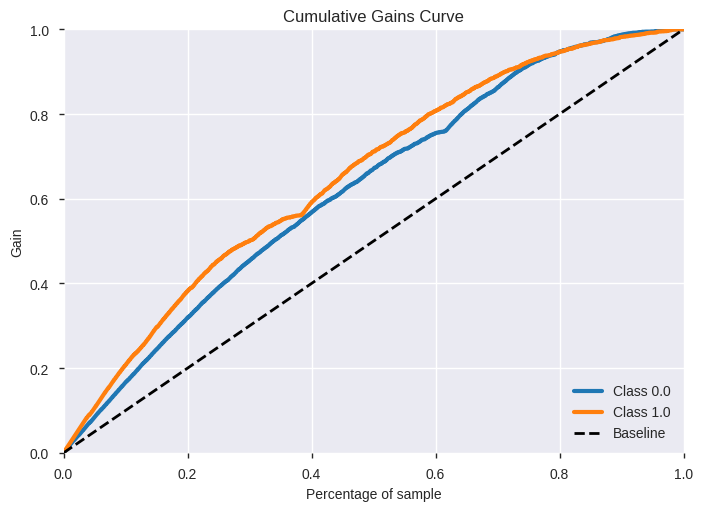

In [129]:
skplt.metrics.plot_cumulative_gain(y_test, grid.best_estimator_.predict_proba(X_test))
plt.show()

In [ ]:
# do we not need to standard scale the data !

#No, because you only nbeed to do this if the data is not normal
# check this with np.var on each column

# and if needed then scale only those columns,
# why would we need to scale or should we feature engineer with skewed data ?
# how do we check for skewed data ?

# feature selection is only for performance optimalization and overfitting on noise (~20 important features)

# therefore we need to use ELI5 to check for feature importance using permutationimportance of the features
# but this is more for inference reasons

# make a cumulative gain plot just for fun to see the importance of the features

In [130]:
from sklearn.preprocessing import StandardScaler

In [131]:
scaler = StandardScaler()

In [133]:
X_train = scaler.fit_transform(X_train)

/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
